In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIPS
from PIPS import OC
PIPS.about()

In /Users/jamessunseri/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jamessunseri/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jamessunseri/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/jamessunseri/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jamessunseri/anaconda3

--------------------------
-    Welcome to PIPS!    -
--------------------------
Version: 0.3.0-alpha.6
Authors: Y. Murakami, A. Savel, J. Sunseri, A. Hoffman
--------------------------
Download the latest version from: https://pypi.org/project/astroPIPS
Report issues to: https://github.com/SterlingYM/astroPIPS
Read the documentations at: https://PIPS.readthedocs.io
--------------------------



- Jurcsik: https://arxiv.org/pdf/1109.4525.pdf  https://academic.oup.com/mnras/article/419/3/2173/1065746
- Corwin: https://iopscience.iop.org/article/10.1086/323918/fulltext/

- O-C method: https://arxiv.org/pdf/astro-ph/0010005.pdf

# data

In [2]:
corwin  = pd.read_csv('corwin.txt',delim_whitespace=True,skiprows=13)
corwin.head()

,name,JD,filter,mag
0,v1,2448755.668,B,16.364
1,v1,2448755.683,B,16.429
2,v1,2448755.698,B,16.394
3,v1,2448755.714,B,16.162
4,v1,2448755.751,B,14.961


In [3]:
jurcsik = pd.read_csv('jurcsik.txt',delim_whitespace=True)
jurcsik.head()

,#star,HJD-2400000,mag,band,source
0,V001,38502.421,16.19,pg,B
1,V001,38502.438,15.97,pg,B
2,V001,38502.452,15.89,pg,B
3,V001,38502.468,15.26,pg,B
4,V001,38502.539,15.06,pg,B


# Initialize PIPS photdata for Jurcsik & KAIT datasets

In [5]:
# Corwin data
corwin_name = 'v6'
band = 'V'

cut = (corwin['name']==corwin_name) & (corwin['filter']==band)
x = corwin[cut]['JD'].to_numpy() - 2400000
y = corwin[cut]['mag'].to_numpy()
yerr = 0.01 * np.ones_like(y)
star_C01 = PIPS.photdata([x,y,yerr],label='Corwin')

In [6]:
# Jurcsik data
jurcsik_name = 'V006'
band = 'V'

cut = (jurcsik['#star']==jurcsik_name) & (jurcsik['band']==band)
x = jurcsik[cut]['HJD-2400000'].to_numpy()
y = jurcsik[cut]['mag'].to_numpy()
yerr = 0.01 * np.ones_like(y)
star_J11 = PIPS.photdata([x,y,yerr],label='Jurcsik')

In [7]:
# initialize PIPS photdata
LPP_datafile = 'M3_Data/m3_V006.dat'
band='V'

data = PIPS.data_readin_LPP(LPP_datafile,filter=band)
star_KAIT = PIPS.photdata(data,label='KAIT')
star_KAIT.cut(yerr_max=0.05)

# Use PIPS.OC module

In [8]:
# initialize OC object
photdata_list = [star_C01,star_J11,star_KAIT]
oc = OC.longdata(photdata_list)

# run OC!
ref_v1 = 0.52061350
ref_v6 = 0.51432675
ref_v3 = 0.558204 
oc.run_OC(p_ref=ref_v6,template_idx=0,Nterms=7,p_min=0.2,p_max=0.9)

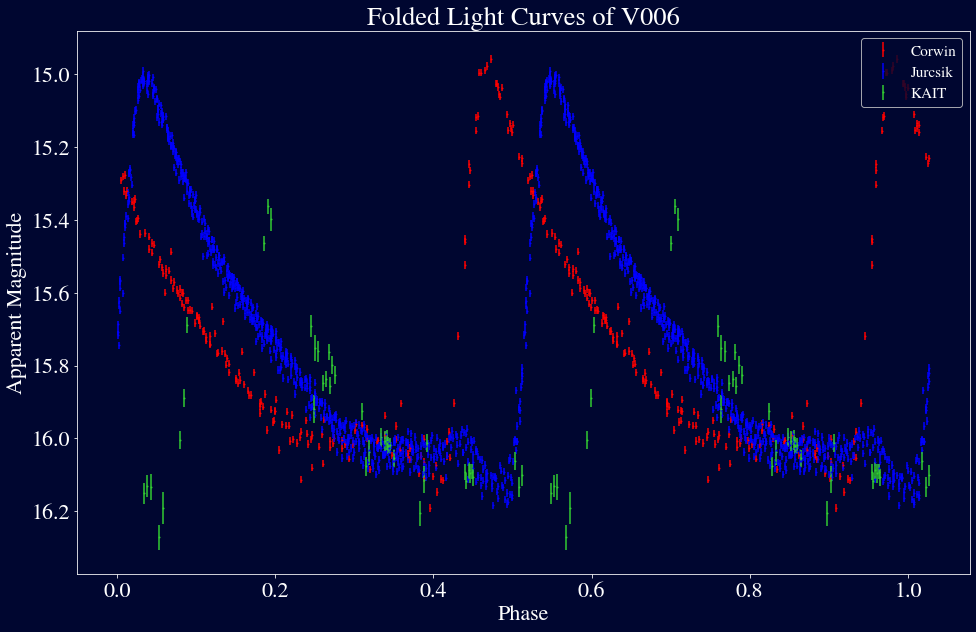

In [9]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 22
plt.style.use("dark_background")

### Text Color ###
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '1.0'  # white (value goes from 0 to 1)
    
### Figure Color ###
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#000630'  # Hex Color Code for Background Color
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]



oc.plot_lc(figsize=(16,12))
plt.title("Folded Light Curves of V006")
plt.ylabel("Apparent Magnitude")
plt.xlabel("Phase")
plt.legend(loc='upper right', fontsize='x-small')
plt.savefig('lightcurves_VOO6.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# outputs
print('O-C:',[float(f'{val:.4f}') for val in oc.oc])      # O-C values
print('err:',[float(f'{val:.4f}') for val in oc.oc_err])  # O-C uncertainties
print('MJD:',[float(f'{val:.1f}') for val in oc.x_means]) # mean x-values
print(f'p_ref: {oc.p_ref:.6f}')   # 'mean' period

# check:
# this value should agree with the offset in O-C values 
# between Jurcsik and Corwin.

# correct for rounding ('round','floor','ceil',etc.)
offset_JC = oc.oc[1]-oc.oc[0]
if offset_JC > oc.p_ref/2:
    offset_JC -= oc.p_ref
elif offset_JC < -oc.p_ref/2:
    offset_JC += oc.p_ref
    
print(f'Jurcsik - Corwin: {offset_JC:.5f}')

# the result:
# this is the OC-value offset between Jurcsik and KAIT!
# (simply add this to Jurcsik's O-C value to get ours in the same frame)
print(f'KAIT - Jurcsik: {oc.oc[2]-oc.oc[1]:.5f}') 

O-C: [-0.1484, -0.0656, 0.0202]
err: [0.0003, 0.0002, 0.0012]
MJD: [48984.9, 54929.3, 59327.3]
p_ref: 0.514327
Jurcsik - Corwin: 0.08283
KAIT - Jurcsik: 0.08578


In [10]:
0.52061350/2

0.26030675

In [11]:
0.52061350 - (oc.oc[1]-oc.oc[0])

0.43778474346969953

In [12]:
period = 0.5
Jurcsik_OC = 0.2
offset = 0.2
Jurcsik_OC + offset - period

-0.09999999999999998